# Clasificación de un Compuesto de Medianas

En el presente notebook se hace la clasificación de un compuesto temporal de medianas extraido del repositorio
de imgágenes del **Cubo de Datos de Imágenes de Satélite de Colombia** en el IDEAM. Un compuesto es un una imagen
libre de nubes contruida por medio de una serie de tomas en el tiempo.

## Referencias

1. http://cdcol.ideam.gov.co/profile/home/

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Carga de un Archivo tif

La función **open_rasterio** permite cargar los datos deun archivo Geotiff en un arreglo multidimensional. La forma del arreglo depende de cómo haya sido generado el archivo por parte del IDEAM.

In [2]:
from rasterio.plot import show
import pandas as pd
import numpy as np
import xarray as xr

# Wofs imports
import gc
import collections
# Genrales
import rasterio
import os
import glob
import random

# ## Carga de Archivos .tif

# path = '../data/choco/LC080100562018011001T1-SC20191101092114'
# path = '../data/choco/LC080100562018022701T1-SC20191101092059'

def find_band_path(band_name,path):
    lookup = path + '/*.tif'
    bands_paths = glob.glob(lookup)
    
    condition = lambda file_name: band_name in file_name
    result = list(filter(condition,bands_paths))

    # result debería tener un único valor desde que 
    # un único path contiene el string que representa
    # la variable band_name
    assert len(result) == 1, 'Nombre de la banda incompleto'
    return result.pop(0)

def load_data_array(tif_path):
    array = xr.open_rasterio(tif_path)
    # Remueve la primer dimensión
    # para obtener un arreglo de dos dimensiones
    return array.squeeze(axis=0)


def load_data(path,bands_mapping):
    bands_dict = {}
    for band_name, alias in bands_mapping:
        bands_dict[alias] = load_data_array(find_band_path(band_name,path))
        
    return bands_dict

In [3]:
path = '../../data/rio_amazonas'

print(path)

band_names = [
    ('band2','blue'),
    ('band3','green'),
    ('band4','red'),
    ('band5','nir'),
    ('band6','swir1'),
    ('band7','swir2'),
    ('pixel_qa','pixel_qa'),
]

# | blue | green | red | nir | swir1 | swir2 | wofs | bosque |
# |------|-------|-----|-----|-------|-------|------|--------|
# |      |       |     |     |       |       |      |        |

data_array = load_data(path,band_names)
blue = data_array['blue'].values
green = data_array['green'].values
red = data_array['red'].values
nir = data_array['nir'].values
swir1 = data_array['swir1'].values
swir2 = data_array['swir2'].values

data = np.array([
blue,
green,
red,
nir,
swir1,
swir2]
)
data

../../data/rio_amazonas


array([[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]],

       [[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]],

       [[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -99

In [4]:
# Muestra de una banda de la imágen multi espectral
# data[1].plot()

## Transformación del Arreglo para la Clasificación

La transformación consiste en transponer el arrleglo multidimensional de tal forma que los valores de las bandas queden en un arreglo y no dispersos en diferentes arreglos. El siguie ejemplo es una muestra de la salida anterior. El primer arreglo bidimencional (commienza con **275.5**) corresponde a los datos en latitud y longitud de la primera banda de la imagén. El segundo arreglo commienza con **181.**) corresponde a la segúnda banda de la imágen. 

```python
[[ **275.5**,  260. ,  218. , ..., 1076. ,  999. ,  950.5],
[ 325. ,  251. ,  264.5, ..., 1017. , 1002.5,  859. ],
[ 278. ,  322. ,  262.5, ...,  961. ,  880.5,  801.5],
...,
[ 562. ,  599. ,  553. , ..., 1085.5, 1022. , 1139. ],
[ 541. ,  564. ,  568. , ...,  879.5,  782. ,  803. ],
[ 495. ,  509. ,  566. , ...,  973. ,  869. ,  793. ]],

[[ **181.** ,  175.5,  155. , ..., 2120.5, 2009. , 1928. ],
[ 205. ,  168.5,  178.5, ..., 2081. , 2016.5, 1807. ],
[ 181. ,  185. ,  176. , ..., 2096. , 1915. , 1777. ],
...,
[ 815. ,  884. ,  815. , ..., 1032. , 1271. , 2090.5],
[ 807. ,  855. ,  866. , ..., 1507. , 1274. , 1364. ],
[ 699. ,  782. ,  852. , ..., 1195. , 1026. , 1370. ]]
```

El objetivo de este paso es que los valores de las bandas **275.5** **181.** queden en la misma lista para facilitar el procesamiento de la imágen. La salida entonces es algo similar a

```python
[[[ **275.5**,  **181.** ,  213.5,  377. ,  215. ,  213.5],
    [ 325. ,  205. ,  251. ,  443. ,  254. ,  250. ],
    [ 278. ,  181. ,  204. ,  406. ,  209. ,  224. ],
    ...,
```

In [5]:
inv = np.transpose(data)
print('Shape:', inv.shape)
inv

Shape: (7591, 7731, 6)


array([[[-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999]],

       [[-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999]],

       [[-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        ...,
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999],
        [-9999, -9999, -9999, -9999, -9999, -9999]],

       ...,

      

## Carga del Modelo de Machine Learning y Clasificación de la Imágen Multiespectral

* Clase 0:Color azul oscuro (wofs): Agua
* Clase 1:Color azul (bosque): Bosque
* Clase 2:Color azul verde (wofs_bosque): Agua o Bosque
* Clase 3:Color verde (cloud): Nubes
* Clase 4:Color amarillo (ninguno): Ninguna de las coverturas anteriores. Puedes ser repreentar una urbanización.

In [6]:
from keras.models import load_model
model = load_model("model.h5")

Using TensorFlow backend.


In [7]:
def compute(array):
    probabilities = []
    for i in range(0,array.shape[0]):
        probabilities.append(model.predict(array[i]))
    
    result = np.array(probabilities)
    # Axis = 2 es la dimesnion que contiene las probabilidad des 
    # de las predicciones realizadas sobre las bandas espectrales
    result = np.argmax(result,axis=2)
    result = np.transpose(result)
    return result

%time clasified = compute(inv)

CPU times: user 10min 36s, sys: 40.4 s, total: 11min 16s
Wall time: 8min 57s


In [8]:
clasified

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

## Predicciónes

Como se puede observar en las predicciones generadas a partir de imagenes satelitales del rio amazonas, el modelo es capaz de predecir exitosamente la selva amazonica y las nubes. El agua del rio amazonas no es predecido correctamente, sin embargo, el modelo es capaz de detectar una anomalía en su area. Esto se puede deber a que los datos utilizados para el entrenamiento del modelo son de la costa del Chocó, por lo cual el color del agua es distinto. Corrimos el mismo algoritmo sobre imagenes de la costa en la Guajira, observamos que reconocia en mayor medida el color del mar, sin embargo, continuó prediciendo el agua como bosque en grandes areas.

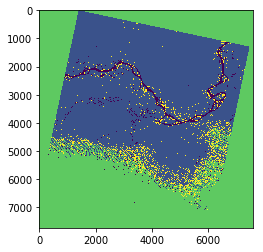

In [27]:
# La imagen resultado no tiene sistema de coordenadas
plt.imshow(clasified)

In [28]:
# Define las coordenadas de los puntos
coords = {'x':data_array['blue'].x.values,'y':data_array['blue'].y.values}

# Define el orden de las dimensiones
dims = ('y','x')

# Define los metadatos o atributos
attrs = {
    'crs': data_array['blue'].crs,
    'transform': data_array['blue'].transform
}

data_array_nn = xr.DataArray(data=clasified,coords=coords,dims=dims)

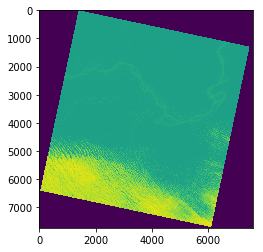

In [29]:
plt.imshow(data[2])

## Agregar Sistema de Coordenadas a la Imágen Clasificada

Dado de la imágen que resulta de al clasificación es un arreglo **np.array** de dos dimensiones, no contiene
los datos de localización de la imágen que permitirá su ubicación en el mapa. Usarémos los datos de localización que se obtuvieron al principio del notebook cuando se carga el archivo .tif.

In [30]:
# Define las coordenadas de los puntos
coords = {'x':data_array['blue'].x.values,'y':data_array['blue'].y.values}

# Define el orden de las dimensiones
dims = ('y','x')

# Define los metadatos o atributos
attrs = {
    'crs': data_array['blue'].crs,
    'transform': data_array['blue'].transform
}

data_array_nn = xr.DataArray(data=clasified,coords=coords,dims=dims)

In [31]:
# data_array.plot.save()
plt.imsave('example1.png', clasified)
plt.imsave('example2.png', data[0])

In [14]:
x_min = min(data_array['blue'].x.values) 
x_max = max(data_array['blue'].x.values)
y_min = min(data_array['blue'].y.values) 
y_max = max(data_array['blue'].y.values) 
(x_min,x_max,y_min,y_max)

(261000.0, 488700.0, -596100.0, -364200.0)

# Clasificación con Naive Bayes

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import datasets
from collections import Counter

from joblib import dump
from sklearn.externals import joblib

#from keras.models import model_from_json

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

/home/estudiante/fcrv/jupyter_notebooks/data_analisis_env_py3/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [16]:
nb_model_path = './model_nb_multinomial.joblib'
nb_model = joblib.load(nb_model_path)

In [17]:
nb_model.predict([[4415.0,4694.0,4728.0,4888.0,4886.0,4312.0]])

array(['ninguno'], dtype='<U11')

In [18]:
def compute_nb(array):
    probabilities = []
    for i in range(0,array.shape[0]):
        probabilities.append(nb_model.predict(array[i]))
    
    result = np.array(probabilities)
    # Axis = 2 es la dimesnion que contiene las probabilidad des 
    # de las predicciones realizadas sobre las bandas espectrales
    result = np.transpose(result)
    return result

clasified_nb = compute_nb(inv)

In [19]:
clasified_nb

array([['bosque', 'bosque', 'bosque', ..., 'bosque', 'bosque', 'bosque'],
       ['bosque', 'bosque', 'bosque', ..., 'bosque', 'bosque', 'bosque'],
       ['bosque', 'bosque', 'bosque', ..., 'bosque', 'bosque', 'bosque'],
       ...,
       ['bosque', 'bosque', 'bosque', ..., 'bosque', 'bosque', 'bosque'],
       ['bosque', 'bosque', 'bosque', ..., 'bosque', 'bosque', 'bosque'],
       ['bosque', 'bosque', 'bosque', ..., 'bosque', 'bosque', 'bosque']],
      dtype='<U11')

In [21]:
# El número corresponde con el orden en las columnas de las etiquetas 
# para el conjuto de entrenamiento

clases = { 
    'wofs': 0,
    'bosque': 1,
    'wofs_bosque': 2,
    'cloud':3,
    'ninguno':4
}

for k,v in clases.items():
    clasified_nb[clasified_nb == k] = v

In [22]:
clasified_nb = clasified_nb.astype(int)
clasified_nb

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [23]:
# Define las coordenadas de los puntos
coords = {'x':data_array['blue'].x.values,'y':data_array['blue'].y.values}

# Define el orden de las dimensiones
dims = ('y','x')

# Define los metadatos o atributos
attrs = {
    'crs': data_array['blue'].crs,
    'transform': data_array['blue'].transform
}

data_array_nb = xr.DataArray(data=clasified_nb,coords=coords,dims=dims)

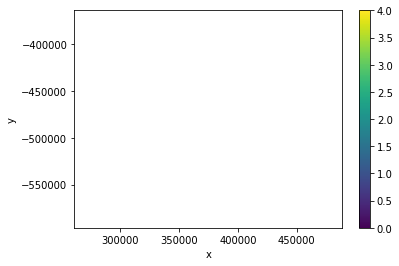

In [24]:
data_array_nb.plot()

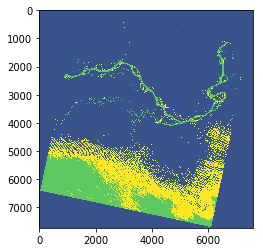

In [25]:
show(data_array_nb)

In [26]:
plt.imsave('example_naive_bayes.png', data_array_nb)